<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/gwbf-notebooks/blob/main/4_GSLB_merge_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Load ML model BFD results

In [ ]:
import pandas as pd
import geopandas as gpd
import glob
import os
import time

def load_streamflow_data(data_folder):
    """
    Load all CSV files from the specified folder, parsing 'Date' column as datetime

    Parameters:
    data_folder: Path to the folder containing streamflow CSV files

    Returns:
    Dictionary: Keys are file names (without .csv), values are DataFrames
    """
    streamflow_data = {}
    csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

    for file_path in csv_files:
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        # Parse 'Date' column as datetime while reading the CSV
        df = pd.read_csv(file_path, parse_dates=['Date'])
        streamflow_data[file_name] = df

    print(f"Loaded {len(streamflow_data)} CSV files: {list(streamflow_data.keys())}")
    return streamflow_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/My Drive/xueyi_research/GSLB_gages/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
streamflow_data = load_streamflow_data(data_folder)


Loaded 68 CSV files: ['10141000', '10026500', '10041000', '10134500', '10157500', '10015900', '10092700', '10105900', '10132000', '10106000', '10128500', '10159500', '10167000', '10133650', '10155500', '10129900', '10118000', '10136500', '10020300', '10171000', '10143500', '10132500', '10155000', '10079500', '10104700', '10153100', '10163000', '10155200', '10038000', '10133800', '10131000', '10168000', '10011500', '10130500', '10126000', '10020100', '10172860', '10152000', '10104900', '10039500', '10046500', '10142000', '10125500', '10109000', '10129300', '10172700', '10139300', '10023000', '10109001', '10113500', '10133600', '10016900', '10146000', '10102250', '10150500', '10137500', '10172952', '10140100', '10129500', '10154200', '10153800', '10058600', '10146400', '10015700', '10164500', '10068500', '10156000', '10168500']


In [ ]:
type(streamflow_data) # To check the type of the streamflow_data variable itself


dict

In [ ]:
measurements.head()

,AquiferID,Well_ID,Date,WTE,State
0,1,381033113480701,2012-09-06,7092.99,UT
1,1,381037113474001,2012-09-06,7175.95,UT
2,1,381152113442801,1995-11-22,6200.00,UT
3,1,381236113485601,2014-07-23,7151.00,UT
4,1,382113113435401,2008-09-03,5395.95,UT


# 2.Create pairs

In [ ]:
result_df = pd.read_csv('result.csv')
result_df['Date'] = pd.to_datetime(result_df['Date'])  # Convert 'Date' to datetime

In [ ]:
def find_pairs(streamflow_data, final_measurements_delta, output_dir='output', float_precision=3):
    """
    Finds pairs of well data and streamflow data based on matching dates and ML_BFD filter.
    Saves individual CSV files for each gage ID.

    Args:
        streamflow_data (dict): Dictionary of streamflow DataFrames.
        final_measurements_delta (pd.DataFrame): DataFrame containing well data with Delta_WTE.
        output_dir (str): Directory to store the output CSV files.

    Returns:
        list: List of created CSV filenames.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    created_files = []  # Keep track of created files

    for gage_id, streamflow_df in streamflow_data.items():
        print(f"Working on Gage {gage_id}")
        start = time.time()

        # Filter streamflow data based on ML_BFD
        filtered_streamflow = streamflow_df[streamflow_df['ML_BFD'] == 1][['Date', 'Q']]
        print(f"Filtered Streamflow Data Shape: {filtered_streamflow.shape}")

        # Add gage_id to the filtered streamflow data
        filtered_streamflow['gage_id'] = gage_id

        # Ensure 'Date' column in final_measurements_delta is datetime
        final_measurements_delta['Date'] = pd.to_datetime(final_measurements_delta['Date'])

        # Perform the merge operation
        paired = filtered_streamflow.merge(
            final_measurements_delta[['Well_ID', 'Date', 'Delta_WTE', 'WTE']],
            on='Date',
            how='inner'  # Only keep matches
        )

        # Reorder columns to place 'gage_id' first
        paired = paired[['gage_id'] + [col for col in paired.columns if col != 'gage_id']]

        # Reduce precision of float columns
        float_columns = paired.select_dtypes(include=['float64', 'float32']).columns
        for col in float_columns:
            paired[col] = paired[col].round(float_precision).astype('float32')

        # Write to individual file if pairs were found
        if not paired.empty:
            output_file = os.path.join(output_dir, f'paired_gage_{gage_id}.csv')
            paired.to_csv(output_file, index=False)
            created_files.append(output_file)

        # Clear memory
        del filtered_streamflow
        del paired

        print(f"Finished Gage {gage_id} with {(time.time() - start):.1f} seconds")

    return created_files

In [ ]:
created_files = find_pairs(
    streamflow_data=streamflow_data,
    final_measurements_delta=result_df,
    output_dir='paired_data',
    float_precision=3
)

Working on Gage 10141000
Filtered Streamflow Data Shape: (825, 2)
Finished Gage 10141000 with 0.0 seconds
Working on Gage 10026500
Filtered Streamflow Data Shape: (3319, 2)
Finished Gage 10026500 with 0.0 seconds
Working on Gage 10041000
Filtered Streamflow Data Shape: (1533, 2)
Finished Gage 10041000 with 0.0 seconds
Working on Gage 10134500
Filtered Streamflow Data Shape: (11491, 2)
Finished Gage 10134500 with 0.0 seconds
Working on Gage 10157500
Filtered Streamflow Data Shape: (9100, 2)
Finished Gage 10157500 with 0.0 seconds
Working on Gage 10015900
Filtered Streamflow Data Shape: (1948, 2)
Finished Gage 10015900 with 0.0 seconds
Working on Gage 10092700
Filtered Streamflow Data Shape: (5811, 2)
Finished Gage 10092700 with 0.0 seconds
Working on Gage 10105900
Filtered Streamflow Data Shape: (8304, 2)
Finished Gage 10105900 with 0.0 seconds
Working on Gage 10132000
Filtered Streamflow Data Shape: (7076, 2)
Finished Gage 10132000 with 0.0 seconds
Working on Gage 10106000
Filtered Str

# 3.Plot

In [ ]:
def analyze_single_gage(gage_id, input_dir='paired_data', legend_ncol=3):
    """
    Analyze and plot Q-Delta_WTE relationship for a single gage from its CSV file.

    Parameters:
    -----------
    gage_id : str
        The gage ID to analyze
    input_dir : str
        Directory containing the paired data files
    legend_ncol : int
        Number of columns in legend

    Returns:
    --------
    dict: Regression statistics for the gage
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy import stats
    import numpy as np
    import os

    # Read the gage's data file
    file_path = os.path.join(input_dir, f'paired_gage_{gage_id}.csv')

    try:
        gage_data = pd.read_csv(file_path)
        print(f"\nAnalyzing gage {gage_id}")
        print(f"Data shape: {gage_data.shape}")

        # Convert Date to datetime
        if 'Date' in gage_data.columns:
            gage_data['Date'] = pd.to_datetime(gage_data['Date'])

        # Create plot and get statistics
        stats = plot_wte_q_relationship(
            gage_data,
            legend_ncol=legend_ncol
        )

        stats['gage_id'] = gage_id

        # Print summary statistics
        print(f"\nAnalysis Results for Gage {gage_id}:")
        print(f"Number of wells: {stats['n_wells']}")
        print(f"Number of measurements: {stats['n_measurements']}")
        if stats['overall_r2'] is not None:
            print(f"R²: {stats['overall_r2']:.3f}")
            print(f"Slope: {stats['slope']:.3f}")
            print(f"P-value: {stats['p_value']:.3f}")
        else:
            print("Insufficient data for regression analysis")

        return stats

    except FileNotFoundError:
        print(f"No data file found for gage {gage_id} at {file_path}")
        return None

def plot_wte_q_relationship(gage_data, fig_size=(12, 8), legend_ncol=3):
    """
    Create scatter plot for a single gage's Q-Delta_WTE relationship

    Parameters:
    -----------
    gage_data : DataFrame
        Data for one gage with columns: Q, Delta_WTE, Well_ID
    fig_size : tuple
        Figure size (width, height)
    legend_ncol : int
        Number of columns in legend
    """
    gage_id = gage_data['gage_id'].iloc[0]

    # Create figure
    plt.figure(figsize=fig_size)

    # Plot data for each well with different colors
    unique_wells = gage_data['Well_ID'].unique()
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(unique_wells)))

    legend_info = []
    for well_id, color in zip(unique_wells, colors):
        well_data = gage_data[gage_data['Well_ID'] == well_id]

        # Plot scatter points
        plt.scatter(well_data['Q'], well_data['Delta_WTE'],
                   color=color, alpha=0.7, s=60,
                   label=f'Well {well_id}\nn={len(well_data)}')

        legend_info.append(f'Well {well_id}\nn={len(well_data)}')

    # Calculate regression line if enough data points
    if len(gage_data) >= 2:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            gage_data['Q'], gage_data['Delta_WTE'])

        x_range = np.array([gage_data['Q'].min(),
                           gage_data['Q'].max()])
        plt.plot(x_range, slope * x_range + intercept,
                'r--', alpha=0.7, linewidth=2)

        legend_info.append(f'Overall regression\nR² = {r_value**2:.2f}')

        regression_stats = {
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value
        }
    else:
        regression_stats = {
            'slope': None,
            'r_squared': None,
            'p_value': None
        }

    # Customize plot
    plt.title(f'Q-Delta_WTE Relationship for Gage {gage_id}\n'
             f'{len(unique_wells)} wells, {len(gage_data)} measurements',
             fontsize=14, pad=20)

    plt.xlabel('Streamflow (m³/s)', fontsize=12)
    plt.ylabel('Delta WTE (m)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=10, ncol=legend_ncol)

    plt.tight_layout()
    plt.show()

    return {
        'n_wells': len(unique_wells),
        'n_measurements': len(gage_data),
        'overall_r2': regression_stats['r_squared'],
        'slope': regression_stats['slope'],
        'p_value': regression_stats['p_value']
    }





Analyzing gage 10011500
Data shape: (219, 6)


<ipython-input-22-735c53d857d8>:131: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


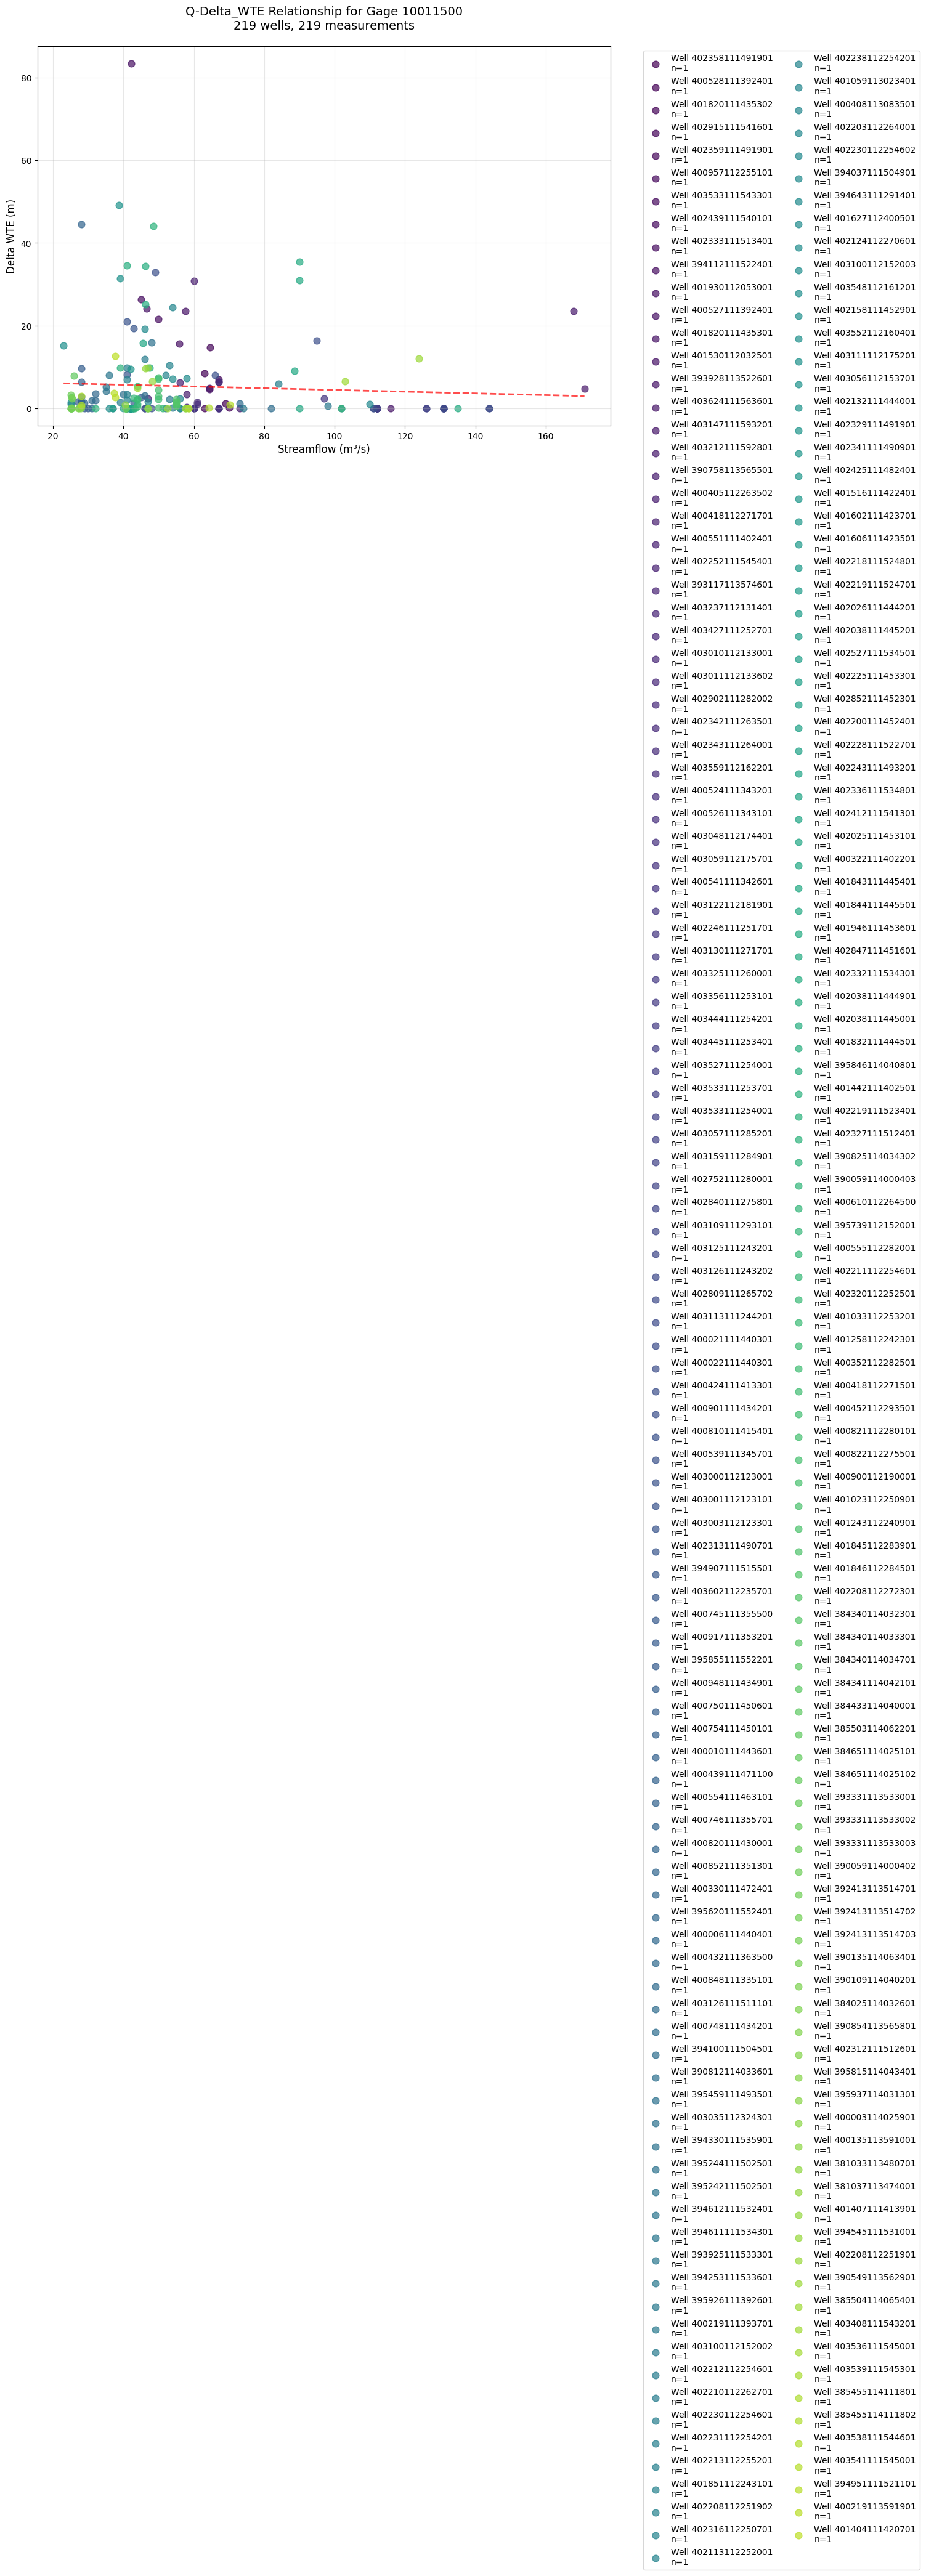


Analysis Results for Gage 10011500:
Number of wells: 219
Number of measurements: 219
R²: 0.003
Slope: -0.021
P-value: 0.384


In [ ]:
# Example usage
gage_id = '10011500'
stats = analyze_single_gage(
    gage_id=gage_id,
    input_dir='/content',  # Colab's local file path
    legend_ncol=2
)